[link dataset](https://www.kaggle.com/datasets/doctrinek/oxford-iiit-cats-extended-10k)

# Setup

### command line

In [1]:
!pip install -q split-folders
!pip install -q opendatasets

### import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib, zipfile, os, splitfolders, datetime
import opendatasets as od

### download dataset

In [3]:
_URL = 'https://www.kaggle.com/datasets/doctrinek/oxford-iiit-cats-extended-10k'
od.download(_URL)

100%|██████████| 993M/993M [00:12<00:00, 82.0MB/s]


### split into train and validation

In [4]:
PATH = '/content/oxford-iiit-cats-extended-10k/CatBreedsRefined-v3'

In [5]:
splitfolders.ratio(PATH, output='/content/project', seed=64, ratio=(0.8, 0.2))
train_dir = '/content/project/train'
validation_dir = '/content/project/val'

Copying files: 10257 files [00:03, 2669.40 files/s]


### define variables

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

### create tf.data.Dataset

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 8202 files belonging to 12 classes.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2055 files belonging to 12 classes.


In [9]:
class_names = train_dataset.class_names
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

print("Class Names:", class_names)
print("Class Indices:", class_indices)

Class Names: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'Bristish Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']
Class Indices: {'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'Bristish Shorthair': 4, 'Egyptian Mau': 5, 'Maine Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian Blue': 9, 'Siamese': 10, 'Sphynx': 11}


# Data Exploration

### show the first nine images from the training set

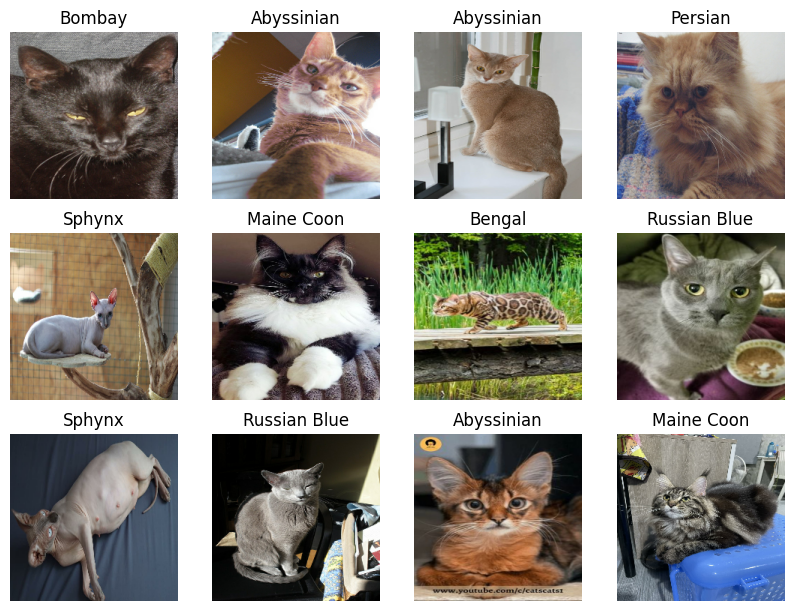

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### show data samples

In [11]:
def total_sample(directory):
  total = 0
  for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    total += len(os.listdir(folder_path))

  return total

train_sample_length = total_sample(train_dir)
validation_sample_length = total_sample(validation_dir)
print(f"The train directory has {train_sample_length} samples")
print(f"The validation directory has {validation_sample_length} samples")
print(f"Which in total makes it {train_sample_length + validation_sample_length} samples")

The train directory has 8202 samples
The validation directory has 2055 samples
Which in total makes it 10257 samples


# Preprocessing

### configure dataset performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### implement data augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomZoom(width_factor=0.2, height_factor=0.2),
    tf.keras.layers.RandomWidth(factor=0.2),
    tf.keras.layers.RandomHeight(factor=0.2)
])

### visualize data augmentation

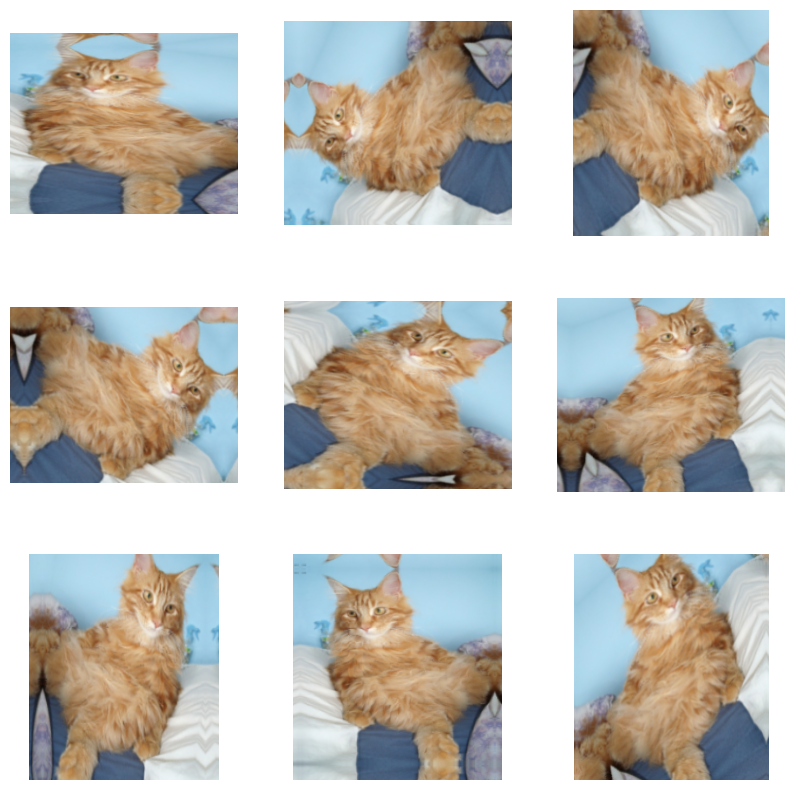

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescale pixel values

In [15]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Model Creation

### callback functions

In [16]:
class SantaiDuluGakSih(tf.keras.callbacks.Callback):
  def __init__(self, sabar_acc=10, sabar_loss=10):
    super(SantaiDuluGakSih, self).__init__()
    self.sabar_acc = sabar_acc
    self.sabar_loss = sabar_loss
    self.limit_acc = sabar_acc
    self.limit_loss = sabar_loss
    self.max_acc = 0
    self.max_val_acc = 0

  def on_epoch_end(self, epoch, logs={}):
    self.max_acc = logs.get('accuracy') if logs.get('accuracy') > self.max_acc else self.max_acc

    self.max_val_acc = logs.get('val_accuracy') if logs.get('val_accuracy') > self.max_val_acc else self.max_val_acc

    if logs.get('accuracy')>=self.max_acc and logs.get('val_accuracy')>=self.max_val_acc:
      self.sabar_acc = self.limit_acc
    else:
      self.sabar_acc -= 1

    if logs.get('loss')>0.75 or logs.get('val_loss')>0.75:
      self.sabar_loss -= 1
    else:
      self.sabar_loss += self.limit_loss

    if self.sabar_acc == 0:
      print(f"The model accuracy has been below {self.max_acc} and {self.max_val_acc} for {self.limit_acc} epochs, Stopping training immediatly!!!")
      self.model.stop_training = True
    elif self.sabar_loss == 0:
      print(f"The model loss has been above 75% for {self.limit_loss} epochs, Stopping training immediatly!!!")
      self.model.stop_training = True
    elif logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
      print(f"The model accuracy has reached 92%, stopping training")
      self.model.stop_training = True

stop_early = SantaiDuluGakSih(sabar_acc=5, sabar_loss=10)

In [17]:
class learningrateLogger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(f"Epoch {epoch+1}/{self.params['epochs']}, Learning Rate: {self.model.optimizer.lr.numpy()}")

lr_log = learningrateLogger()

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.6,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001
)

### create base model

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = MobileNetV2(
    weights="imagenet",
    input_tensor=Input(shape=IMG_SHAPE),
    include_top=False
)

base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
model = tf.keras.Sequential()
model.add(Input(shape=(IMG_SHAPE)))
model.add(data_augmentation)
model.add(rescale)
model.add(base_model)
model.add(Conv2D(64, (3,3), activation=tf.nn.relu))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(12, activation=tf.nn.softmax))

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    737344    
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 64)    0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, None, None, 64)   

In [22]:
int_lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(int_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
initial_epochs = 20

loss0, acc0 = model.evaluate(validation_dataset)

65/65 [==============================] - 19s 187ms/step - loss: 3.3644 - accuracy: 0.0847


In [24]:
modelku = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    verbose=2,
    callbacks=[stop_early, reduce_lr, lr_log]
)

Epoch 1/20
Epoch 1/20, Learning Rate: 0.0010000000474974513
257/257 - 79s - loss: 1.1958 - accuracy: 0.6070 - val_loss: 0.7284 - val_accuracy: 0.7533 - lr: 0.0010 - 79s/epoch - 308ms/step
Epoch 2/20
Epoch 2/20, Learning Rate: 0.0010000000474974513
257/257 - 71s - loss: 0.8830 - accuracy: 0.7007 - val_loss: 0.6954 - val_accuracy: 0.7513 - lr: 0.0010 - 71s/epoch - 275ms/step
Epoch 3/20
Epoch 3/20, Learning Rate: 0.0010000000474974513
257/257 - 77s - loss: 0.8274 - accuracy: 0.7259 - val_loss: 0.6079 - val_accuracy: 0.7903 - lr: 0.0010 - 77s/epoch - 298ms/step
Epoch 4/20
Epoch 4/20, Learning Rate: 0.0010000000474974513
257/257 - 76s - loss: 0.7887 - accuracy: 0.7438 - val_loss: 0.5196 - val_accuracy: 0.8263 - lr: 0.0010 - 76s/epoch - 296ms/step
Epoch 5/20
Epoch 5/20, Learning Rate: 0.0010000000474974513
257/257 - 69s - loss: 0.7752 - accuracy: 0.7392 - val_loss: 0.5870 - val_accuracy: 0.8039 - lr: 0.0010 - 69s/epoch - 267ms/step
Epoch 6/20
Epoch 6/20, Learning Rate: 0.0010000000474974513


### plot transfer learning

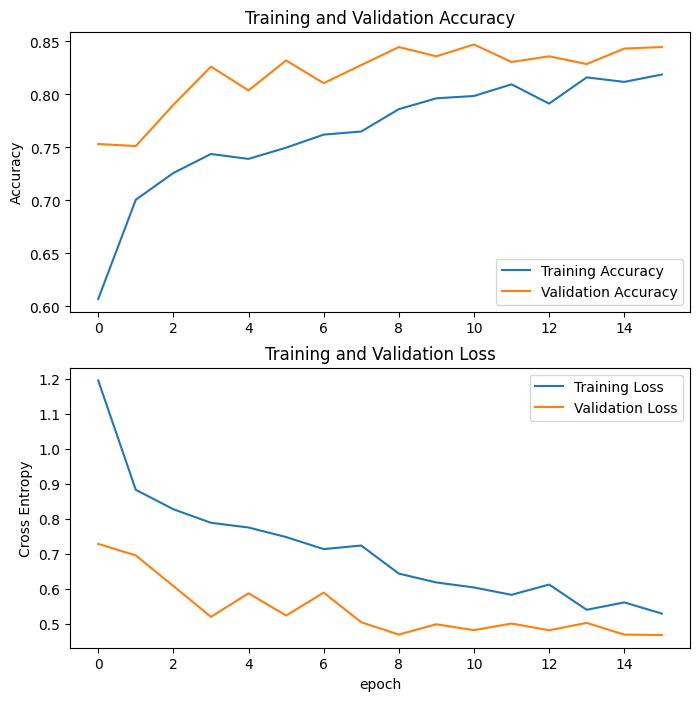

In [25]:
acc = modelku.history['accuracy']
val_acc = modelku.history['val_accuracy']

loss = modelku.history['loss']
val_loss = modelku.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [26]:
base_model.trainable = True

In [27]:
print("Jumlah layer di base_model: ", len(base_model.layers))

fine_tune_di = 100

for layer in base_model.layers[:fine_tune_di]:
  layer.trainable = False

Jumlah layer di base_model:  154


In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(int_lr/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    737344    
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 64)    0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, None, None, 64)   

In [30]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

modelku_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=modelku.epoch[-1],
    validation_data=validation_dataset,
    verbose=2,
    callbacks=[stop_early, reduce_lr, lr_log]
)

Epoch 16/30
Epoch 16/30, Learning Rate: 9.999999747378752e-05
257/257 - 81s - loss: 0.7800 - accuracy: 0.7474 - val_loss: 0.6428 - val_accuracy: 0.7903 - lr: 1.0000e-04 - 81s/epoch - 315ms/step
Epoch 17/30
Epoch 17/30, Learning Rate: 9.999999747378752e-05
257/257 - 68s - loss: 0.6209 - accuracy: 0.7903 - val_loss: 0.6104 - val_accuracy: 0.8044 - lr: 1.0000e-04 - 68s/epoch - 263ms/step
Epoch 18/30
Epoch 18/30, Learning Rate: 9.999999747378752e-05
257/257 - 77s - loss: 0.5591 - accuracy: 0.8169 - val_loss: 0.4643 - val_accuracy: 0.8428 - lr: 1.0000e-04 - 77s/epoch - 298ms/step
Epoch 19/30
Epoch 19/30, Learning Rate: 9.999999747378752e-05
257/257 - 67s - loss: 0.5271 - accuracy: 0.8244 - val_loss: 0.4820 - val_accuracy: 0.8394 - lr: 1.0000e-04 - 67s/epoch - 261ms/step
Epoch 20/30
Epoch 20/30, Learning Rate: 9.999999747378752e-05
257/257 - 68s - loss: 0.4754 - accuracy: 0.8452 - val_loss: 0.4206 - val_accuracy: 0.8496 - lr: 1.0000e-04 - 68s/epoch - 265ms/step
Epoch 21/30
Epoch 21/30, Learn

### plot fine tuning

In [31]:
acc += modelku_fine.history['accuracy']
val_acc += modelku_fine.history['val_accuracy']

loss += modelku_fine.history['loss']
val_loss += modelku_fine.history['loss']

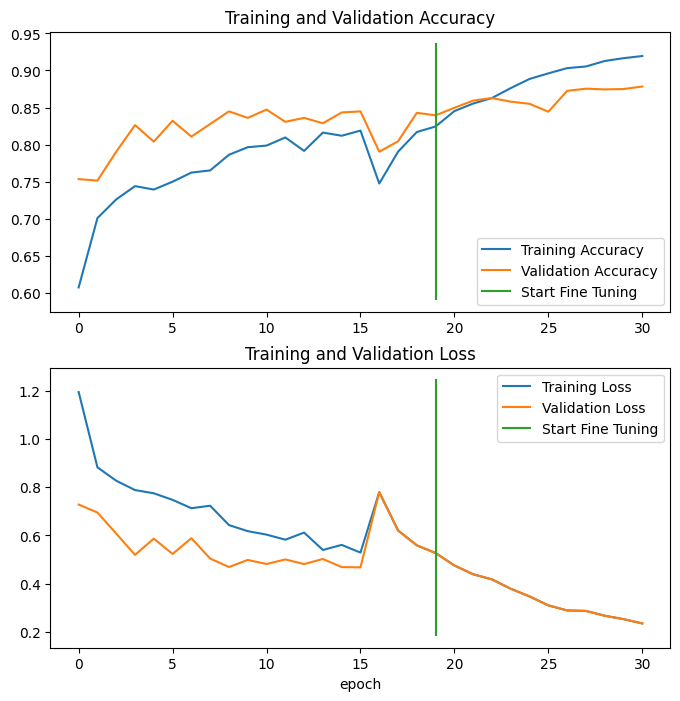

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# model evaluation

In [33]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

65/65 [==============================] - 13s 168ms/step - loss: 0.4160 - accuracy: 0.8783
Test accuracy : 0.8783454895019531


Saving Abyssinian_10.jpg to Abyssinian_10.jpg
Saving Bristish Shorthair_1.jpg to Bristish Shorthair_1.jpg
Saving Russian Blue_10.jpg to Russian Blue_10.jpg


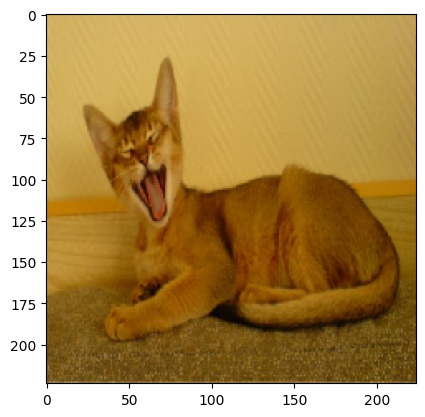

1/1 [==============================] - 2s 2s/step
Predicted Class: Abyssinian
Confidence Score: 1.0


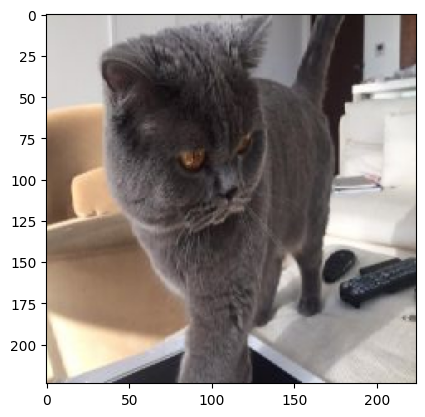

1/1 [==============================] - 0s 28ms/step
Predicted Class: British Shorthair
Confidence Score: 0.9999339580535889


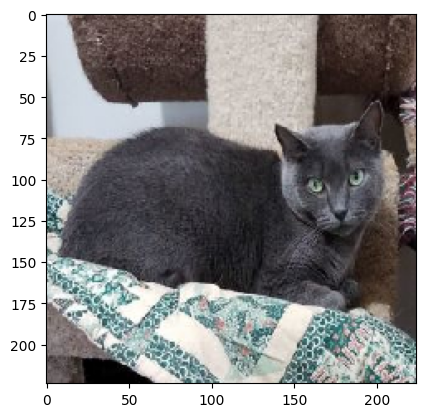

1/1 [==============================] - 0s 38ms/step
Predicted Class: Russian Blue
Confidence Score: 0.9999359846115112


In [35]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

class_labels = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau',
                'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']

for fn in uploaded.keys():

  #predict gambar
  path = fn
  img = image.load_img(path, target_size=IMG_SIZE)

  imgplot = plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  confidence_score = classes[0][predicted_index]

  predicted_label = class_labels[predicted_index]

  print(f"Predicted Class: {predicted_label}")
  print(f"Confidence Score: {confidence_score}")

# Save Model

In [36]:
# menyimpan model dalam format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

11896920